# Style Transfer with Neural Networks
### Ariane ALIX and Marie Heurtevent

#### To reload the *.py* dependencies automatically

In [1]:
%reload_ext autoreload
%autoreload 2

#### To disable the automatic scrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Importation of libs

In [3]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

from IPython.display import display, Math

Populating the interactive namespace from numpy and matplotlib


## Definition of Network and processing/evaluation functions

### Definition of the Network

In [4]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

### Classes for Gram matrix and loss

In [5]:
from gram import GramMatrix
from gram import GramMSELoss

### Transformations and functions for pre-processing

In [6]:
from processing import *

## Application

### Initialize Network

Loading pre-trained state

In [7]:
# Get network
vgg = VGG()

# Load a state downloaded
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

### Load images

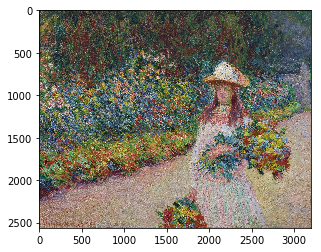

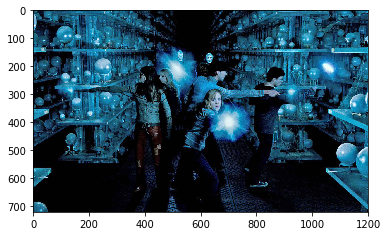

In [17]:
#### load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['monet.jpg', 'hp.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]


#### Transform to CUDA format if using GPU
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    
style_image, content_image = imgs_torch
opt_img = Variable(content_image.data.clone(), requires_grad=True)


#### Display the loaded images
for img in imgs:
    plt.imshow(img)
    plt.show()

### Define losses, layers, targets... -> experiment with others

In [23]:
### Define layers, loss functions
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
    
### Define weights
style_weights = [1/5]*5
content_weights = [1e0]
weights = style_weights + content_weights


### Compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + 10000*content_targets

In [28]:
# Reinitialise l'image de départ qui est l'image de contenu
opt_img = Variable(content_image.data.clone(), requires_grad=True)

max_iter = 1000
show_iter = 500
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        if n_iter[0]%show_iter == show_iter-1:
            start_time = time.time()

        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()

        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == 0:
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data.item()))
            print("Time taken for one iteration:",time.time()-start_time)
            #print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss

    optimizer.step(closure)

Iteration: 501, loss: 1208053.750000
Time taken for one iteration: 0.36574625968933105
Iteration: 1001, loss: 697744.437500
Time taken for one iteration: 0.3540525436401367


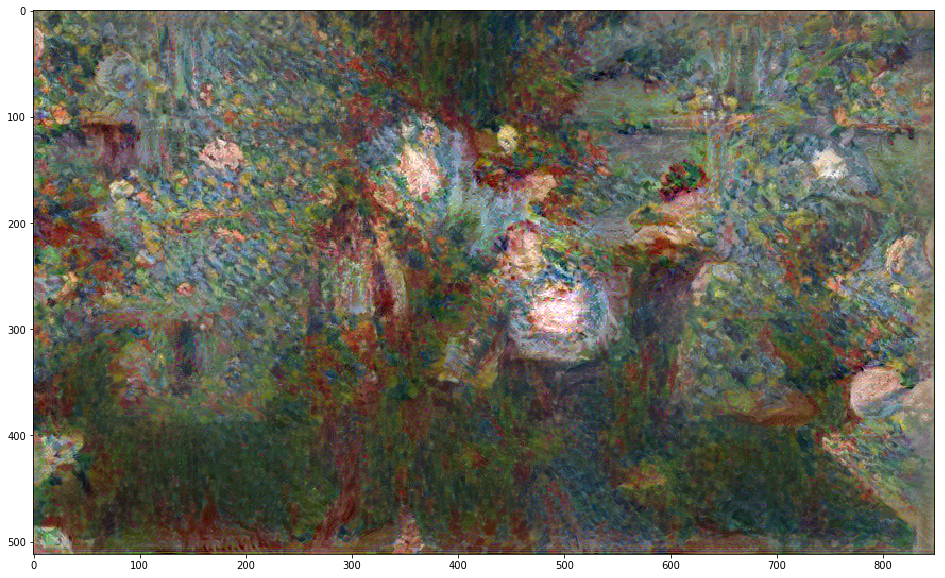

In [29]:
plt.figure(figsize=(20,10))
plt.imshow(postp(opt_img.data[0].cpu().squeeze()))

plt.show()

## Expérimentations avec différents  alpha and beta -> trade-off entre contenu et style

In [10]:
list_alpha_beta=[(1000,1),(100,1),(1,1),(0.01,1),(0.001,1),(0.0001,1)]

In [11]:
list_targets=[]
for (alpha,beta) in list_alpha_beta:
    content = [c*alpha for c in content_targets]
    style = [s*beta for s in style_targets]
    
    list_targets.append(style + content)

### Run style transfer!

In [27]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [17]:
### Pour toutes les combinaisons de alpha et beta pour la fonction de perte
list_opt_imgs=[]

for i in range(6):
    target = list_targets[i]
    (alpha,beta) = list_alpha_beta[i]
    
    print("Calcul du transfert de style pour alpha =",alpha,"et beta =",beta)
    
    # Reinitialise l'image de départ qui est l'image de contenu
    opt_img = Variable(content_image.data.clone(), requires_grad=True)
    
    max_iter = 500
    show_iter = 250
    optimizer = optim.LBFGS([opt_img]);
    n_iter=[0]

    while n_iter[0] <= max_iter:

        def closure():
            if n_iter[0]%show_iter == show_iter-1:
                start_time = time.time()

            optimizer.zero_grad()
            out = vgg(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, target[a]) for a,A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            
            n_iter[0]+=1
            #print loss
            if n_iter[0]%show_iter == 0:
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data.item()))
                print("Time taken for one iteration:",time.time()-start_time)
                #print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
            return loss

        optimizer.step(closure)
    list_opt_imgs.append(opt_img)

Calcul du transfert de style pour alpha = 1000 et beta = 1
Iteration: 251, loss: 630431154176.000000
Time taken for one iteration: 0.35405516624450684
Iteration: 501, loss: 630386786304.000000
Time taken for one iteration: 0.3650243282318115
Calcul du transfert de style pour alpha = 100 et beta = 1
Iteration: 251, loss: 6266369024.000000
Time taken for one iteration: 0.37699341773986816
Iteration: 501, loss: 6242942976.000000
Time taken for one iteration: 0.3779911994934082
Calcul du transfert de style pour alpha = 1 et beta = 1
Iteration: 251, loss: 26437570.000000
Time taken for one iteration: 0.37400054931640625
Iteration: 501, loss: 8318949.500000
Time taken for one iteration: 0.3779897689819336
Calcul du transfert de style pour alpha = 0.01 et beta = 1
Iteration: 251, loss: 26333138.000000
Time taken for one iteration: 0.37399792671203613
Iteration: 501, loss: 8090611.500000
Time taken for one iteration: 0.3759946823120117
Calcul du transfert de style pour alpha = 0.001 et beta = 

### Display results

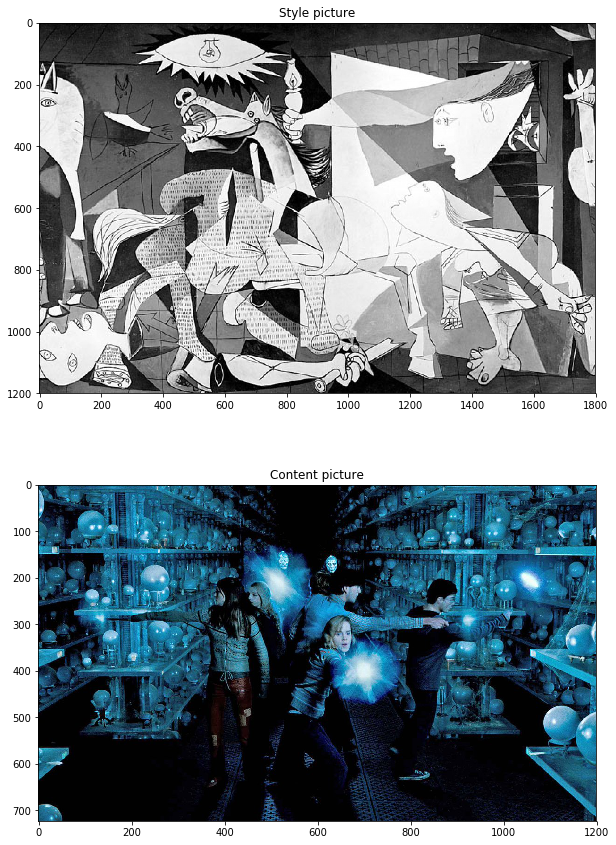

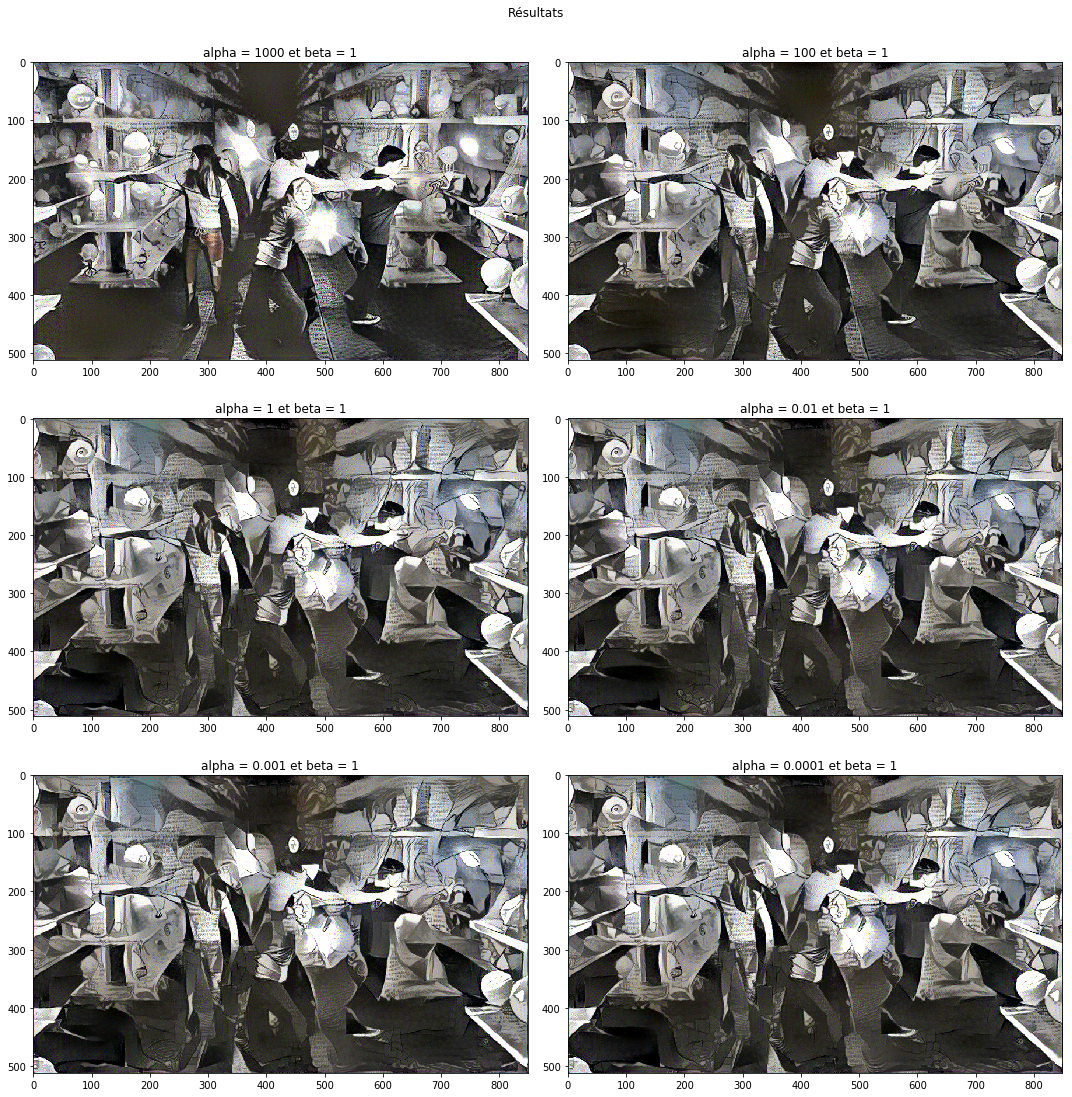

In [33]:
### Display input pictures

fig = plt.figure(figsize=(10,15))
axs = fig.subplots(2,1)

axs[0].imshow(imgs[0])
axs[0].set_title("Style picture")

axs[1].imshow(imgs[1])
axs[1].set_title("Content picture")

plt.show()


### Affichage des résultas pour les différents alpha et beta
fig = plt.figure(figsize=(15,15))
axs = fig.subplots(3,2)

for i in range(len(list_opt_imgs)):

    out_img = postp(list_opt_imgs[i].data[0].cpu().squeeze())
    (alpha,beta) = list_alpha_beta[i]

    axs[int(i/2),i%2].imshow(out_img)
    axs[int(i/2),i%2].set_title("alpha = "+str(alpha)+" et beta = "+str(beta))

plt.suptitle('Résultats', y=1.02)
plt.tight_layout()
plt.show()

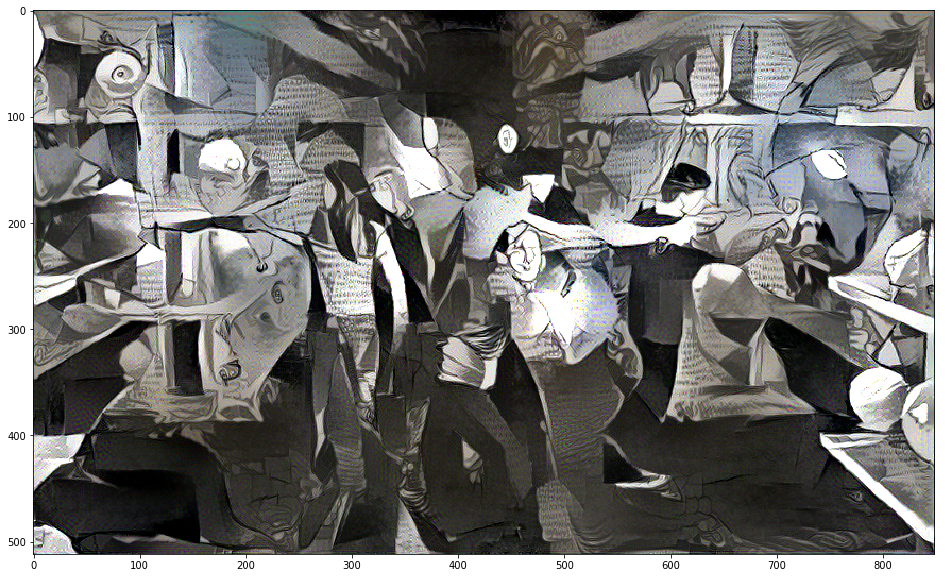

In [27]:
plt.figure(figsize=(20,10))

plt.imshow(postp(list_opt_imgs[5].data[0].cpu().squeeze()))

plt.show()